<a href="https://colab.research.google.com/github/o4lc/PINN-CBF/blob/main/F16/F16_DeepReach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Fixed-Wing Plane
This 10D system has 7D state and 3D control variables
$$x = [y_1,y_2,y_3, \phi, \theta, \psi, s]^T,\quad u = [a, p, q]^T$$
We describe the control affine system $\dot x = f(x) + g(x)u$ as follows

$$
f(x) = \begin{bmatrix} \textbf{v}(\zeta)\\ \textbf{f}_{\xi}(x)\\0 \end{bmatrix},\quad g(x) =  \begin{bmatrix} 0_{3\times 3}\\ \textbf{g}_{\xi}(x)\\ 1\; 0\;  0\; \end{bmatrix}
$$

$$
\textbf{f}_{\xi}(x)= \frac{g_D}{s}\begin{bmatrix} \sin(\phi)\cos(\phi)\sin(\theta)\\ -(\sin(\phi))^2\cos (\theta)\\ \sin(\phi)\cos(\phi)  \end{bmatrix},\quad
\textbf{g}_{\xi}(x)= \begin{bmatrix} 0 & 1 & \sin(\phi)\tan(\theta)\\ 0 & 0 & \cos (\phi)\\ 0 & 0 & \frac{\sin(\phi)}{\cos(\theta)}  \end{bmatrix}
$$


$$
r =\begin{bmatrix} y_1\\y_2\\y_3 \end{bmatrix},\quad \zeta = \begin{bmatrix} s\\ \theta\\ \psi \end{bmatrix}, \quad \textbf{v}(\zeta) = \begin{bmatrix} s\cos(\theta)\cos(\psi)\\ s\cos(\theta)\sin(\psi) \\ -s\sin(\theta) \end{bmatrix}
$$

$$g_D=\text{ gravitational acceleration}\approx 9.81$$
Recall $$\dot{h}(x) = \nabla h(x)^T\dot{x} = \nabla h(x)^T(f(x) + g(x)u)$$


DeepReach is also a physics informed method but enforces the HJ-PDE For finite time.
Let
$$ h_{\theta}(x,t) = c(x) - \delta_{\theta}(x,t)$$
Substitute into the HJ-PDE found in equation (13) of Choi et al., 2021
$$\mathcal{L}_{HJ}(x,t;\theta, \gamma) = \min\bigg\{\delta_{\theta}(x,t), -\frac{\partial}{\partial t}\delta_{\theta}(x,t) +  \max_{u\in \mathcal{U}}
 \nabla_x(c(x) - \delta_{\theta}(x,t))^T(f(x) + g(x)u) + \gamma(c(x) - \delta_{\theta}(x,t))\bigg\}^2$$
$$\mathcal{L}_{T}(x,T;\theta, \gamma) = \delta_{\theta}(x,T)^2$$
$$\mathcal{L}(x,t;\theta, \gamma) = \mathcal{L}_{T}(x,T;\theta, \gamma) + \lambda \mathcal{L}_{HJ}(x,t;\theta, \gamma) $$

A cirriculum learning approach is used for training, where $\lambda = 0$ ininially and gradually increased. Spatial samples are kept constant throughout training.  

Using the filtering simulations from the other methods, we can set a reasonable time horizon to train on. Training time is scaled to $[0,T]$. Based on the past DI filtering simulations $T=4$ would be reasonable. We do not rescale time to $[0, 1]$ like in the paper because then space would also have to be rescaled leading to different error behavior of the residuals.

$$\lambda_T = 0,\; \lambda_0 = 1$$
DeepReach uses a cirrculum learning approach where $t$ is decreased linearly from $T$ and $\lambda$ regularizer increases linearly after being held at 0 for the first 1/11th of the iterations. Though the original paper adopts a fixed step size, we observe that a decreasing step size achieves better results.

For validation we use the model at $t=0$.


(times and spatial coordinates are independent so times need not be stored)

In [ ]:
!pip install dill
import dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
import jax
import numpy as onp
import jax.numpy as np
from jax import random, grad, hessian, vmap, jit, config, ops
from jax.nn import sigmoid, relu, elu, softplus, swish, tanh
from jax.example_libraries import optimizers
import jaxlib

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter  # For animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation
import matplotlib.lines as mlines



import cvxpy as cp
import scipy.sparse as sp

import gc

%matplotlib inline


In [ ]:
#For GPU use, check the device before importing anything from torch
jaxlib_version = jaxlib.__version__
print("jaxlib version:", jaxlib_version)
jax_version = jax.__version__
print("JAX version:", jax_version)
print(jax.local_devices())

jaxlib version: 0.4.33
JAX version: 0.4.33
[CudaDevice(id=0)]


In [ ]:
from torch.utils import data
print(jax.local_devices())

[CudaDevice(id=0)]


In [ ]:
# Build custom activation
def custom_softplus(x, beta=1):
    return (1 / beta) * np.log1p(np.exp(beta * x)) #This beta can't be large, causes gradient overflow during training
def custom_tanh(x, beta=1):
    return np.tanh(beta * x)

softplus = partial(custom_softplus, beta=1)
tanh = partial(custom_tanh, beta=1)

In [ ]:
##Hyperparameters
#training hyperparameters not used in this notebook

#Model
input_dim = 8 # 7 + 1(time)
output_dim = 1
layers = [input_dim, 100, 100, output_dim]
activation = tanh #tanh, elu, custom
output_activation = softplus # softplus, swish, custom

#Cfunc
num_obstacles = 5
beta = 8 #5
sharpness = 8 #1
x_min, x_max, y_min, y_max, z_min, z_max = -5, 5, -5, 5, 0, 10

phi_min, phi_max = -2 * np.pi, 2 * np.pi #Restriction for plotting purposes only
theta_min, theta_max = -2 * np.pi, 2 * np.pi #Restriction for plotting purposes only
psi_min, psi_max = -2 * np.pi, 2 * np.pi #Restriction for plotting purposes only
speed_min, speed_max = 1, 10    #Restriction for plotting purposes only

s_min, s_max = .5, 3 #obstacle size restrictions

T = 4 #Terminal time ()

#training
P_train = 1000000 # number of random samples for training
batch_size = 1000000
epochs = 10000

lambda_0 = 0
lambda_T = 1

ilr = 1e-4 #DeepReach paper uses fixed learning rate
flr = 1e-4
total_steps = epochs * (P_train / batch_size)

decay_rate = .8
if decay_rate < 1 and flr < ilr:
    decay_steps = int(total_steps * np.log(decay_rate) / np.log(flr/ilr))
else:
    decay_steps = 1e9

#u = [a,p,q] these are the max magnitude, this makes the inner maximization simple
a = 10.5
p = 1
q = 1
control_max = np.array([a, p, q])

g_d = 9.81 #Downward gravitational acceleration


#Residuals
gamma = .1

p = 2

#Validation
P_val = 1000000 # 1M
num_val = 10
# Total val samples = 1M * 10 = 10M
# Due to memory issues compute the validation over 10 equally sized chunks and average. Clear memory between chunks

In [ ]:
#We only consider obstacles in the spatial coordinates. These will be rectangular without rotation
#[s1, s2, s3, x_c, y_c, z_c]
def generate_obstacles(key, numrect):
    key_side1s, key_side2s, key_side3s, key_center1s, key_center2s, key_center3s = random.split(key, 6)
    s1 = random.uniform(key_side1s, shape=(numrect,), minval=s_min, maxval=s_max)
    s2 = random.uniform(key_side2s, shape=(numrect,), minval=s_min, maxval=s_max)
    s3 = random.uniform(key_side3s, shape=(numrect,), minval=s_min, maxval=s_max)
    xc = random.uniform(key_center1s, shape=(numrect,), minval=x_min, maxval=x_max)
    yc = random.uniform(key_center2s, shape=(numrect,), minval=y_min, maxval=y_max)
    zc = random.uniform(key_center3s, shape=(numrect,), minval=z_min, maxval=z_max)
    obstacles = np.column_stack((s1, s2, s3, xc, yc, zc))

    return obstacles

# Set the seed for reproducibility
key = random.PRNGKey(3)
# Generate shapes
obstacles = generate_obstacles(key, num_obstacles)

print(obstacles)

[[ 2.4310408   0.5634      0.83959985 -2.7140927  -4.965748    3.0102992 ]
 [ 2.272633    2.015176    2.6459553   2.7192688   2.378913    0.7998383 ]
 [ 1.8110167   2.2451193   0.8462061  -4.4116535   3.0615664   5.5112066 ]
 [ 2.7823331   0.943272    2.9259653   1.9415941   0.31349277  6.1720276 ]
 [ 2.135333    2.0035467   1.1468735   4.3816204  -3.4133792   2.714206  ]]


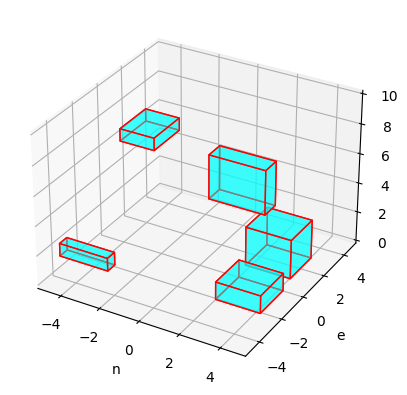

In [ ]:
# Function to plot rectangular obstacles centered on the obstacles
def plot_obstacles_centered(obstacles):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #max_coords = np.max([np.max(np.abs(np.array(obstacle)[:3])) for obstacle in obstacles])

    for obstacle in obstacles:
        s1, s2, s3, xc, yc, zc = obstacle
        vertices = np.array([[xc - s1/2, yc - s2/2, zc - s3/2],
                             [xc + s1/2, yc - s2/2, zc - s3/2],
                             [xc + s1/2, yc + s2/2, zc - s3/2],
                             [xc - s1/2, yc + s2/2, zc - s3/2],
                             [xc - s1/2, yc - s2/2, zc + s3/2],
                             [xc + s1/2, yc - s2/2, zc + s3/2],
                             [xc + s1/2, yc + s2/2, zc + s3/2],
                             [xc - s1/2, yc + s2/2, zc + s3/2]])

        faces = [[vertices[j] for j in [0, 1, 2, 3]],
                 [vertices[j] for j in [4, 5, 6, 7]],
                 [vertices[j] for j in [0, 1, 5, 4]],
                 [vertices[j] for j in [2, 3, 7, 6]],
                 [vertices[j] for j in [0, 3, 7, 4]],
                 [vertices[j] for j in [1, 2, 6, 5]]]

        ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.5))

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    ax.set_xlabel('n')
    ax.set_ylabel('e')
    ax.set_zlabel('d')

    plt.show

plot_obstacles_centered(obstacles)

In [ ]:
#c function
@jit
def obstacle_safety(x, y, z, obstacle):
    s1, s2, s3, xc, yc, zc = obstacle

    # Calculate distances from the edges of the rectangle
    dx_edge = abs(x - xc) - s1 / 2
    dy_edge = abs(y - yc) - s2 / 2
    dz_edge = abs(z - zc) - s3 / 2

    # Calculate the maximum distance outside the obstacle
    max_out = np.max(np.array([dx_edge, dy_edge, dz_edge]))

    return  max_out

@jit
def smooth_obstacle_safety(x, y, z, obstacle, sharpness = sharpness):
    s1, s2, s3, xc, yc, zc = obstacle

    # Calculate distances from the edges of the rectangle
    dx_edge = (np.log(np.exp(sharpness * (x - xc)) + np.exp(sharpness * -(x - xc))) - np.log(2)) / sharpness - s1 / 2
    dy_edge = (np.log(np.exp(sharpness * (y - yc)) + np.exp(sharpness * -(y - yc))) - np.log(2)) / sharpness - s2 / 2
    dz_edge = (np.log(np.exp(sharpness * (z - zc)) + np.exp(sharpness * -(z - zc))) - np.log(2)) / sharpness - s3 / 2

    # Calculate the minimum distance from the boundary
    max_out = (np.log(np.exp(sharpness * dx_edge) + np.exp(sharpness * dy_edge) + np.exp(sharpness * dz_edge)) - np.log(3)) / sharpness #Overuse of sharpness?

    return  max_out

@jit
def cfunc(px, py, pz, obstacles):
    violations = []
    violations.append((px - x_min) * (x_max - px))
    violations.append((py - y_min) * (y_max - py))
    violations.append((pz - z_min) * (z_max - pz))

    for obstacle in obstacles:
        violations.append(obstacle_safety(px, py, pz, obstacle))

    return np.sign(np.min(np.array(violations)))


@jit
def smooth_cfunc(px, py, pz, obstacles, beta=beta):
    sum_exp = np.exp(-beta * np.tanh(px - x_min) * np.tanh(x_max - px)) + np.exp(-beta * np.tanh(py - y_min) * np.tanh(y_max - py)) + np.exp(-beta * np.tanh(pz - z_min) * np.tanh(z_max - pz))

    for obstacle in obstacles:
        sum_exp += np.exp(-beta * np.tanh(smooth_obstacle_safety(px, py, pz, obstacle)))

    log_sum_exp = -np.log(sum_exp) / beta

    return log_sum_exp

#cfunc only takes 3 arguments (x,y,z) while delta takes 7 (x,y,z,phi,theta, psi,s)

In [ ]:
#arbitrary smooth activation van be passed like elu, tanh, silu, softplus, or custom
def MLP(layers, activation=tanh, use_batchnorm=False, init_last_zeros=False, noise_std=1e-8):
    ''' MLP with optional BatchNorm'''
    def init(rng_key):
        def init_layer(key, d_in, d_out, init_zeros=False):
            k1, k2 = random.split(key)
            if init_zeros:
                # W = np.zeros((d_in, d_out))
                # b = np.zeros(d_out)
                W = noise_std * random.normal(k1, (d_in, d_out))
                b = noise_std * random.normal(k2, (d_out,))
            else:
                glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
                W = glorot_stddev * random.normal(k1, (d_in, d_out))
                b = np.zeros(d_out)
            if use_batchnorm:
                # Initialize batchnorm parameters
                scale = np.ones(d_out)
                offset = np.zeros(d_out)
                return W, b, scale, offset
            else:
                return W, b

        key, *keys = random.split(rng_key, len(layers))
        if init_last_zeros:
            params = list(map(init_layer, keys[:-1], layers[:-1], layers[1:], [False]*(len(layers)-1)))
            last_layer_params = init_layer(keys[-1], layers[-2], layers[-1], True)
            params.append(last_layer_params)
        else:
            params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs, is_training=True):
        for layer_params in params[:-1]:
            W, b = layer_params[:2]  # Get weights and biases
            outputs = np.dot(inputs, W) + b
            if use_batchnorm:
                # Extract batchnorm parameters
                scale, offset = layer_params[2:]
                # Compute batch normalization manually
                mean = np.mean(outputs, axis=0)
                variance = np.var(outputs, axis=0)
                normalized_outputs = (outputs - mean) / np.sqrt(variance + 1e-5)
                outputs = scale * normalized_outputs + offset
            outputs = activation(outputs)
            inputs = outputs
        W, b = params[-1][:2]  # Last layer weights and biases
        outputs = np.dot(inputs, W) + b
        return outputs

    return init, apply

In [ ]:
#This functions like a dataloader
class DataGenerator(data.Dataset):
    def __init__(self, y, c, gradc, batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.y = y  # Queries (x,y,z,phi,theta, psi,s)
        self.c = c  # Safety function values corresponding to queries
        self.gradc = gradc #for now only first degree

        self.N = y.shape[0]
        self.batch_size = min(batch_size, self.N)  # Ensure batch_size is smaller than N
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        y, c, gradc = self.__data_generation(subkey)
        return y, c, gradc

    def __len__(self):
        'Denotes the total number of samples'
        return self.N

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        y = self.y[idx, :]
        c = self.c[idx, :]
        gradc = self.gradc[idx, :]

        return y, c, gradc

In [ ]:
def get_gradc(y1, y2, y3, obstacles = obstacles):
    gradc_y1 = grad(smooth_cfunc, argnums=0)(y1, y2, y3, obstacles)
    gradc_y2 = grad(smooth_cfunc, argnums=1)(y1, y2, y3, obstacles)
    gradc_y3 = grad(smooth_cfunc, argnums=2)(y1, y2, y3, obstacles)

    return np.array([gradc_y1, gradc_y2, gradc_y3])


def sample_training_data(key, P=P_train, obstacles=obstacles, sample_outside=True):
    # Generate a batch of random samples
    def generate_samples(key, num_samples):
        key_y1, key_y2, key_y3, key_phi, key_theta, key_psi, key_s = random.split(key, 7)

        y1 = random.uniform(key_y1, (num_samples,), minval=x_min  - (1 - sample_outside), maxval=x_max + (1 - sample_outside))
        y2 = random.uniform(key_y2, (num_samples,), minval=y_min - (1 - sample_outside), maxval=y_max + (1 - sample_outside))
        y3 = random.uniform(key_y3, (num_samples,), minval=z_min - (1 - sample_outside), maxval=z_max + (1 - sample_outside))
        phi = random.uniform(key_phi, (num_samples,), minval=phi_min, maxval=phi_max)
        theta = random.uniform(key_theta, (num_samples,), minval=theta_min, maxval=theta_max)
        psi = random.uniform(key_psi, (num_samples,), minval=psi_min, maxval=psi_max)
        s = random.uniform(key_s, (num_samples,), minval=speed_min, maxval=speed_max)

        return np.column_stack((y1, y2, y3, phi, theta, psi, s)) #multiple samples so use column stack

    # Unified function to compute c values
    def compute_c_values(y_samples):
        c_values_smooth = vmap(smooth_cfunc, (0, 0, 0, None))(y_samples[:, 0], y_samples[:, 1], y_samples[:, 2], obstacles)
        return c_values_smooth

    # Main sampling loop
    y_list = []
    if sample_outside:
        while len(y_list) < P:
            # Generate a batch of samples
            key, subkey = random.split(key)
            batch_size = P - len(y_list) # Adaptive batch size strategy
            y_samples = generate_samples(subkey, batch_size)

            # Compute c values for the entire batch
            c_values = compute_c_values(y_samples)

            # Create a boolean mask for valid samples
            valid_mask = c_values >= 0
            valid_samples = y_samples[valid_mask]

            # Append valid samples to the list
            y_list.extend(valid_samples.tolist())
    else:
         y_samples = generate_samples(key, P)
         y_list.extend(y_samples.tolist())

    # Convert list to array
    y = np.array(y_list)

    # Compute values for c, gradc at sampled points
    c = vmap(smooth_cfunc, (0, 0, 0, None))(y[:, 0], y[:, 1], y[:, 2], obstacles)
    gradc = vmap(get_gradc, (0, 0, 0, None))(y[:, 0], y[:, 1], y[:, 2], obstacles)

    return y, c, gradc

In [ ]:
#F16 affine system f and g
def f_dyn(x, y, z, phi, theta, psi, s):
    v_gamma = np.array([s * np.cos(theta) * np.cos(psi),
                        s * np.cos(theta) * np.sin(psi),
                        -s * np.sin(theta)])
    f_xi = g_d * np.array([np.sin(phi) * np.cos(phi) * np.sin(theta),
                           -(np.sin(phi))**2 * np.cos(theta),
                           np.sin(phi) * np.cos(phi)]) / s

    # Concatenate v_gamma, f_xi, and append a 0
    concatenated_vector = np.concatenate([v_gamma, f_xi, np.array([0])])

    return concatenated_vector

def g_dyn(x, y, z, phi, theta, psi, s):
    g_xi = np.array([[0, 1, np.sin(phi) * np.tan(theta)],
                     [0, 0, np.cos(phi)],
                     [0, 0, np.sin(phi) / np.cos(theta)]])

    concatenated_vector = np.concatenate([np.zeros((3, 3)), g_xi, np.array([[1, 0, 0]])])
    return concatenated_vector

In [ ]:
#No validation until after unlike the DI runs
class PI_MLP:
    def __init__(self, layers, activation=tanh, T = T, output_activation=softplus, use_batchnorm=False, init_last_zeros = False):
        # Network initialization and evaluation functions
        self.init, self.apply = MLP(layers, activation=activation, use_batchnorm=use_batchnorm)
        self.T = T

        # Optimization parameters
        self.output_activation = output_activation


        # Initialize
        params = self.init(rng_key=random.PRNGKey(1234))

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(optimizers.exponential_decay(ilr, decay_steps=decay_steps, decay_rate=decay_rate))

        # Initialize optimizer state for both phases
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()

        self.nIter = int(P_train / batch_size * epochs)

    def update_nIter(self, epochs_new):
        self.nIter = int(P_train / batch_size * epochs_new)

    def net_diff(self, params, y1, y2, y3, phi, theta, psi, s, t):
        input_vector = np.hstack([y1, y2, y3, phi, theta, psi, s, t])
        out = np.squeeze(self.apply(params, input_vector))
        output = softplus(out)

        return output


    def training_residuals(self, params, y1, y2, y3, phi, theta, psi, s, t, c, gradc_y1, gradc_y2, gradc_y3, gamma=gamma):
        res_T = self.net_diff(params, y1, y2, y3, phi, theta, psi, s, self.T)

        output = self.net_diff(params, y1, y2, y3, phi, theta, psi, s, t)
        graddelta_t = np.array(grad(self.net_diff, argnums=(8,))(params, y1, y2, y3, phi, theta, psi, s, t))
        graddelta_x = np.array(grad(self.net_diff, argnums=(1, 2, 3, 4, 5, 6, 7))(params, y1, y2, y3, phi, theta, psi, s, t))
        gradc = np.array([gradc_y1, gradc_y2, gradc_y3, 0, 0, 0, 0])
        f_x = f_dyn(y1, y2, y3, phi, theta, psi, s)
        g_x = g_dyn(y1, y2, y3, phi, theta, psi, s)

        array_HJ = np.array([output, -np.squeeze(graddelta_t) + np.dot(gradc - graddelta_x, f_x) + np.dot(np.abs(g_x.T @ (gradc - graddelta_x)), control_max) + gamma * (np.squeeze(c) - output)])
        res_HJ = np.min(array_HJ, axis = 0)

        return np.array([res_T, res_HJ])


    # Used for validation
    def residuals(self, params, y1, y2, y3, phi, theta, psi, s, c, gradc_y1, gradc_y2, gradc_y3, gamma=gamma):
        output = self.net_diff(params, y1, y2, y3, phi, theta, psi, s, 0)
        graddelta = np.array(grad(self.net_diff, argnums=(1, 2, 3, 4, 5, 6, 7))(params, y1, y2, y3, phi, theta, psi, s, 0))
        gradc = np.array([gradc_y1, gradc_y2, gradc_y3, 0, 0, 0, 0])
        f_x = f_dyn(y1, y2, y3, phi, theta, psi, s)
        g_x = g_dyn(y1, y2, y3, phi, theta, psi, s)


        array_1 = np.array([output, np.dot(gradc - graddelta, f_x) + np.dot(np.abs(g_x.T @ (gradc - graddelta)), control_max) + gamma * (np.squeeze(c) - output)]) # Squeeze must be there because c has 2 dims from dataloader
        res_I = np.min(array_1, axis = 0)

        array_2 = np.array([0,  -np.dot(gradc - graddelta, f_x) - np.dot(np.abs(g_x.T @ (gradc - graddelta)), control_max) - gamma * (np.squeeze(c) - output)])
        res_II = np.max(array_2, axis = 0)
        return np.array([res_I, res_II])


    def loss(self, params, batch, t):
        # Fetch data
        y, c, gradc = batch
        # Compute forward pass
        pred = vmap(self.training_residuals, (None, 0, 0, 0, 0, 0, 0, 0, None, 0, 0, 0, 0))(params, y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4], y[:, 5], y[:, 6], t, c, gradc[:, 0], gradc[:, 1], gradc[:, 2])
        # Compute loss
        # Compute loss
        lamb = abs(T - t) / T
        loss_T = np.mean(pred[:, 0])
        loss_HJ = np.mean(pred[:, 1]**2)

        return loss_T + lamb * loss_HJ

    # Define a compiled update step for phase
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch, t):
        params = self.get_params(opt_state)
        gr = grad(self.loss)(params, batch, t) #The grad function will automatically differentiate only with respect to the first argument (params)
        return self.opt_update(i, gr, opt_state)

    def train(self, train_dataset):
        data = iter(train_dataset)

        pbar = trange(self.nIter)
        for it in pbar:

            # Calculate t based on the current iteration, 1/11 follows from the DeepReach paper
            frac = it / self.nIter
            t = np.where(
            frac < 1/11,
            self.T,
            self.T * (1 - (frac - 1/11) / (1 - 1/11))
            )

            batch = next(data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, batch, t)
            #No print

In [ ]:
# Validation function
# Unfortunatly uniform samplig nwith shifts will be very difficult and require a 7th power of linear density in order to remain uniform. Instead we will use repeated random sampling with a fixed number of keys
def validation(key, model, P_val=P_val, num_val=num_val, sample_outside=True, gamma=gamma):
    # Initialize metrics
    avg_abs_res_I = 0
    avg_safety = 0
    rel_vol = 0

    for i in range(num_val):
        key, subkey = random.split(key)
        y_val, c_val, gradc_val = sample_training_data(subkey, P=P_val, sample_outside=sample_outside)

        ndata = y_val.shape[0]
        params = model.get_params(model.opt_state)

        res_both = vmap(model.residuals, (None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))(params, y_val[:, 0], y_val[:, 1], y_val[:, 2], y_val[:, 3], y_val[:, 4], y_val[:, 5], y_val[:, 6], c_val, gradc_val[:, 0], gradc_val[:, 1], gradc_val[:, 2])

        res_I = res_both[:,0]
        res_II = res_both[:,1]
        abs_res_I = np.abs(res_I)

        delta_val = vmap(model.net_diff, (None, 0, 0, 0, 0, 0, 0, 0, None))(params, y_val[:, 0], y_val[:, 1], y_val[:, 2], y_val[:, 3], y_val[:, 4], y_val[:, 5], y_val[:, 6], 0)
        h_val = c_val - delta_val

        # Compute other metrics
        avg_abs_res_I += np.mean(abs_res_I)
        avg_safety += np.mean(res_II)

        # Compute relative volume
        rel_vol += np.mean(h_val >= 0)

        # Delete large variables to free up memory
        del y_val, c_val, gradc_val, res_both, res_I, res_II, abs_res_I, delta_val, h_val
        gc.collect()  # Optional: trigger garbage collection

    # Print the calculated values
    print(f"Average of abs_res_I: {avg_abs_res_I / num_val}")
    print(f"Average of safety: {avg_safety / num_val}")
    print(f"Relative volume: {rel_vol / num_val}")

##Train

In [ ]:
key = random.PRNGKey(1)
#keys = random.split(key, P_val)
y_train, c_train, gradc_train = sample_training_data(key, sample_outside=False)

In [ ]:
# Create data set
training_data  = DataGenerator(y_train,  np.expand_dims(c_train, axis=1), gradc_train, batch_size = batch_size)

In [ ]:
epochs = epochs
F16_DeepReach = PI_MLP(layers, activation=tanh, T = T, output_activation=softplus, use_batchnorm=False, init_last_zeros = False)

In [ ]:
F16_DeepReach.train(training_data)

100%|██████████| 10000/10000 [44:20<00:00,  3.76it/s]


In [ ]:
# Save and load models
with open('F16_DeepReach.pkl', 'wb') as f:
    dill.dump(F16_DeepReach, f)

# with open('F16_DeepReach.pkl', 'rb') as f:
#     F16_DeepReach = dill.load(f)

In [ ]:
# Validation
key = random.PRNGKey(42)
validation(key, F16_DeepReach)

Exception ignored in: <function _xla_gc_callback at 0x7ff10d75c940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7ff10d75c940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Validation
key = random.PRNGKey(42)
validation(key, F16_DeepReach)

##Filtering

In [ ]:
def euler_to_rotation_matrix(phi, theta, psi):
    R_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])

    R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                    [0, 1, 0],
                    [-np.sin(theta), 0, np.cos(theta)]])

    R_x = np.array([[1, 0, 0],
                    [0, np.cos(phi), -np.sin(phi)],
                    [0, np.sin(phi), np.cos(phi)]])

    return np.dot(R_z, np.dot(R_y, R_x))

In [ ]:
class F16_Controller:
    def __init__(self, initial_state, dt, filter = None, alpha = .05):
        #Controller parameters
        self.initial_state = initial_state
        self.dt = dt  # Time step
        self.alpha = alpha
        self.filter = filter
        if self.filter != None:
            self.filter_params = self.filter.get_params(self.filter.opt_state)


    def f_dynamics(self, x, y, z, phi, theta, psi, s):
        v_gamma = np.array([s * np.cos(theta) * np.cos(psi),
                            s * np.cos(theta) * np.sin(psi),
                            -s * np.sin(theta)])
        f_xi = g_d * np.array([np.sin(phi) * np.cos(phi) * np.sin(theta),
                            -(np.sin(phi))**2 * np.cos(theta),
                            np.sin(phi) * np.cos(phi)]) / s

        # Concatenate v_gamma, f_xi, and append a 0
        concatenated_vector = np.concatenate([v_gamma, f_xi, np.array([0])])

        return concatenated_vector

    def g_dynamics(self, x, y, z, phi, theta, psi, s):
        g_xi = np.array([[0, 1, np.sin(phi) * np.tan(theta)],
                        [0, 0, np.cos(phi)],
                        [0, 0, np.sin(phi) / np.cos(theta)]])

        concatenated_vector = np.concatenate([np.zeros((3, 3)), g_xi, np.array([[1, 0, 0]])])
        return concatenated_vector


    def safety_correction(self, state, u):
        # Define decision variable
        if self.filter == None:
            u = np.clip(u, -control_max, control_max)

            return u
        else:
            #Evaluate the output for an enviornment and state
            delta = self.filter.net_diff(self.filter_params, state[0], state[1], state[2], state[3], state[4], state[5], state[6], 0)
            graddelta = np.array(grad(self.filter.net_diff, argnums=(1, 2, 3, 4, 5, 6, 7))(self.filter_params, state[0], state[1], state[2], state[3], state[4], state[5], state[6], 0))

            gradc = get_gradc(state[0], state[1], state[2], obstacles)
            c = smooth_cfunc(state[0], state[1], state[2], obstacles)

            #compute h and gradh
            h = c - delta

            #print(h)
            padded_gradc = np.pad(gradc, (0, graddelta.shape[0] - gradc.shape[0]))
            gradh =  padded_gradc - graddelta

            f_t = self.f_dynamics(state[0], state[1], state[2], state[3], state[4], state[5], state[6])
            g_t = self.g_dynamics(state[0], state[1], state[2], state[3], state[4], state[5], state[6])

            a = self.alpha
            signh = np.sign(h)
            max_it = 10
            it = 0

            u_var = cp.Variable(shape=(3,))

            while np.any(u_var.value is None) and it < max_it:
                it += 1
                a = a * 1.5 **(signh * it)
                #Quadratic program
                u_var = cp.Variable(shape=(3,))
                u_ref = u

                # Objective
                objective = cp.Minimize(cp.sum_squares(u_var - u_ref))


                # Define constraints
                constraints = [gradh.T @ (f_t + g_t @ u_var) + a * h >= 0,
                                u_var <= control_max,
                                u_var >= -control_max]

                # Formulate the optimization problem
                problem = cp.Problem(objective, constraints)

                # Solve the problem
                problem.solve()
            return u_var.value if problem.status == 'optimal' else None

    def control_policy(self, t):
        A_t = a * t / 8 + 1
        p_t =  p * np.sin(2*t)/4
        q_t = q * np.cos(1*t)/5
        return np.array([A_t, p_t, q_t])

    def control(self, state, t):
        u = self.control_policy(t)
        u = self.safety_correction(state, u)
        return u

    def update_state(self, state, t):
        u_t = self.control(state, t)
        f_t = self.f_dynamics(state[0], state[1], state[2], state[3], state[4], state[5], state[6])
        g_t = self.g_dynamics(state[0], state[1], state[2], state[3], state[4], state[5], state[6])
        return state + self.dt * (f_t + g_t @ u_t)

    def calculate_trajectory(self, T):
        state_trajectory = [self.initial_state]
        t = 0

        while t <= T:
            state = self.update_state(state_trajectory[-1], t)
            state_trajectory.append(state)
            t += self.dt

        return state_trajectory

    #Plot the heatmap of the CBF first and its zero level set. Then Plot the trajectory in between with a blue dashed line and blue start points. Plot the box with a black dashed line
    import matplotlib.lines as mlines
    def plot_trajectories(self, trajectories_list, trajectory_names=None, colors_list=None):
        fig = plt.figure(figsize=(18, 6))

        # Define view angles
        view_angles = [(30, 30), (60, 30), (120, 30), (150, 30)]
        titles = ['View 1: 30° Azimuth, 30° Elevation', 'View 2: 90° Azimuth, 0° Elevation',
                'View 3: 0° Azimuth, 90° Elevation', 'View 4: 60° Azimuth, 70° Elevation']

        # If no custom color list is provided, use a default colormap
        if colors_list is None:
            colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories_list)))
        else:
            assert len(colors_list) == len(trajectories_list), "Length of colors_list must match the number of trajectories."
            colors = colors_list

        for i, (azim, elev) in enumerate(view_angles):
            ax = fig.add_subplot(1, 4, i + 1, projection='3d')

            # Plot obstacles
            for obstacle in obstacles:
                s1, s2, s3, xc, yc, zc = obstacle
                vertices = np.array([[xc - s1 / 2, yc - s2 / 2, zc - s3 / 2],
                                    [xc + s1 / 2, yc - s2 / 2, zc - s3 / 2],
                                    [xc + s1 / 2, yc + s2 / 2, zc - s3 / 2],
                                    [xc - s1 / 2, yc + s2 / 2, zc - s3 / 2],
                                    [xc - s1 / 2, yc - s2 / 2, zc + s3 / 2],
                                    [xc + s1 / 2, yc - s2 / 2, zc + s3 / 2],
                                    [xc + s1 / 2, yc + s2 / 2, zc + s3 / 2],
                                    [xc - s1 / 2, yc + s2 / 2, zc + s3 / 2]])

                faces = [[vertices[j] for j in [0, 1, 2, 3]],
                        [vertices[j] for j in [4, 5, 6, 7]],
                        [vertices[j] for j in [0, 1, 5, 4]],
                        [vertices[j] for j in [2, 3, 7, 6]],
                        [vertices[j] for j in [0, 3, 7, 4]],
                        [vertices[j] for j in [1, 2, 6, 5]]]

                ax.add_collection3d(Poly3DCollection(faces, facecolors='black', linewidths=1, edgecolors='white', alpha=1))

            # Plot trajectories
            for idx, state_trajectory in enumerate(trajectories_list):
                positions = np.array(state_trajectory)[:, 0:3]
                phis = np.array(state_trajectory)[:, 3]
                thetas = np.array(state_trajectory)[:, 4]
                psis = np.array(state_trajectory)[:, 5]
                speeds = np.array(state_trajectory)[:, 6]

                velocity_vectors = []
                for j in range(len(state_trajectory)):
                    velocity_vector = np.array([np.cos(thetas[j]) * np.cos(psis[j]),
                                                np.cos(thetas[j]) * np.sin(psis[j]),
                                                -np.sin(thetas[j])])
                    velocity_vectors.append(velocity_vector)

                velocity_vectors = np.array(velocity_vectors)
                x = positions[:, 0]
                y = positions[:, 1]
                z = positions[:, 2]

                # Plot smaller quivers for velocity vectors with custom colors
                for j in range(0, len(positions), 2):
                    ax.quiver(positions[j, 0], positions[j, 1], positions[j, 2],
                            velocity_vectors[j, 0], velocity_vectors[j, 1], velocity_vectors[j, 2],
                            color=colors[idx], length=1.5, normalize=True)

                initial_position = positions[0]
                final_position = positions[-1]
                ax.scatter(initial_position[0], initial_position[1], initial_position[2], color='b', s=30, label='Initial Position')  # Smaller points
                ax.scatter(final_position[0], final_position[1], final_position[2], color='r', s=30, label='Final Position')  # Smaller points

                # If using filter, plot scatter based on h_values
                if self.filter is not None:
                    cvals = vmap(smooth_cfunc, (0, 0, 0, None))(positions[:, 0], positions[:, 1], positions[:, 2], obstacles)
                    states = np.array(state_trajectory)
                    deltavals = vmap(self.filter.net_diff, (None, 0, 0, 0, 0, 0, 0, 0, None))(
                        self.filter_params, states[:, 0], states[:, 1], states[:, 2], states[:, 3], states[:, 4], states[:, 5], states[:, 6], 0)
                    hvals = cvals - deltavals
                    sc = ax.scatter(x, y, z, c=hvals, cmap='coolwarm', s=30)
                else:
                    ax.scatter(x, y, z, s=30)

            ax.set_xlim(x_min + 1, x_max - 1)
            ax.set_ylim(y_min + 1, y_max - 1)
            ax.set_zlim(z_min + 1, z_max - 1)

            ax.set_xlabel('X', fontsize=16)
            ax.set_ylabel('Y', fontsize=16)
            ax.set_zlabel('Z', fontsize=16)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.tick_params(axis='both', which='minor', labelsize=12)

            ax.view_init(elev, azim)

        # Create a custom legend with trajectory names
        if trajectory_names is not None:
            handles = []
            for idx, name in enumerate(trajectory_names):
                line = mlines.Line2D([], [], color=colors[idx], marker='o', linestyle='None', markersize=10, label=name)
                handles.append(line)
            plt.legend(handles=handles, loc='upper right', fontsize=12)

        plt.tight_layout()
        plt.show()

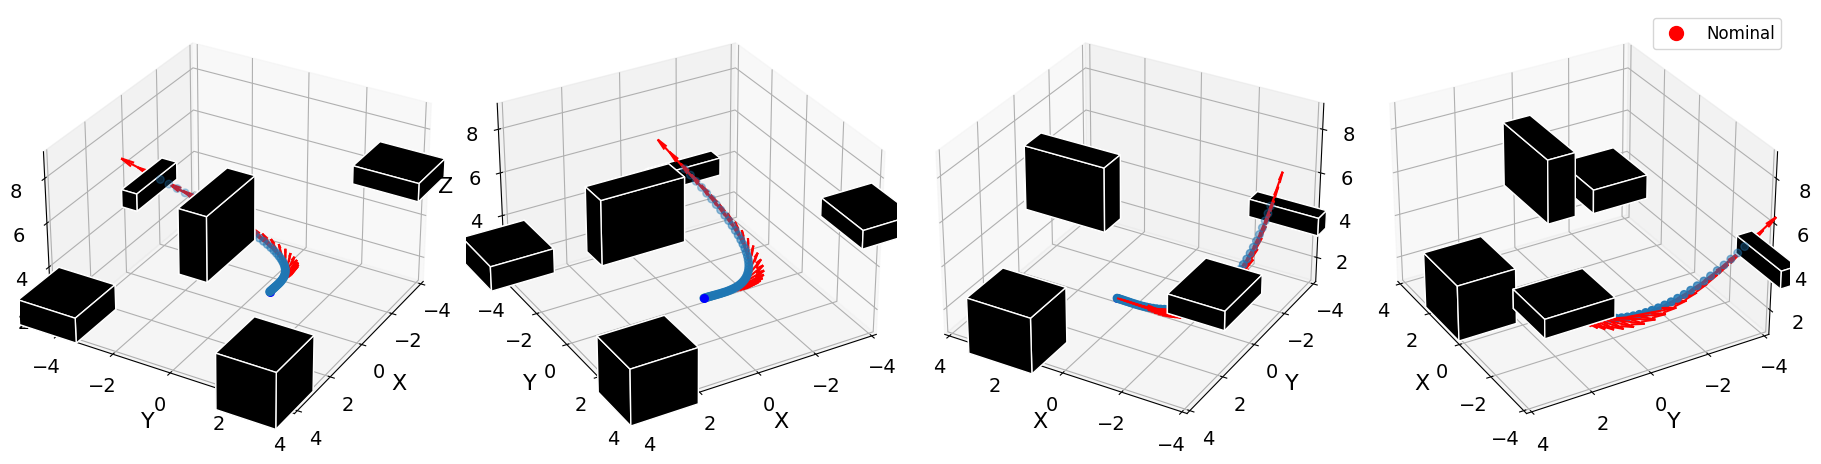

In [ ]:
#Unfiltered trajectory
# initial_state = np.array([0, 1, 2, 0, 0, np.pi, 1])
# initial_state = np.array([-1, -2, 0, 0, 0, 0, 1])
# initial_state = np.array([1.0, -1.5, 5, 0, 0, np.pi/2, 1.0])
initial_state = np.array([0, 1, 2, 0, 0, np.pi, 1])
T = 2.25
dt = 0.05
instance = F16_Controller(initial_state, dt, filter = None, alpha = .05)
trajectory = instance.calculate_trajectory(T)
instance.plot_trajectories([trajectory], ['Nominal'], ['r'])

In [ ]:
#Load Model
# with open('F16_DeepReach.pkl', 'rb') as f:
#     F16_DeepReach = dill.load(f)

AttributeError: Can't get attribute 'shard_arg' on <module 'jax._src.interpreters.pxla' from '/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/pxla.py'>

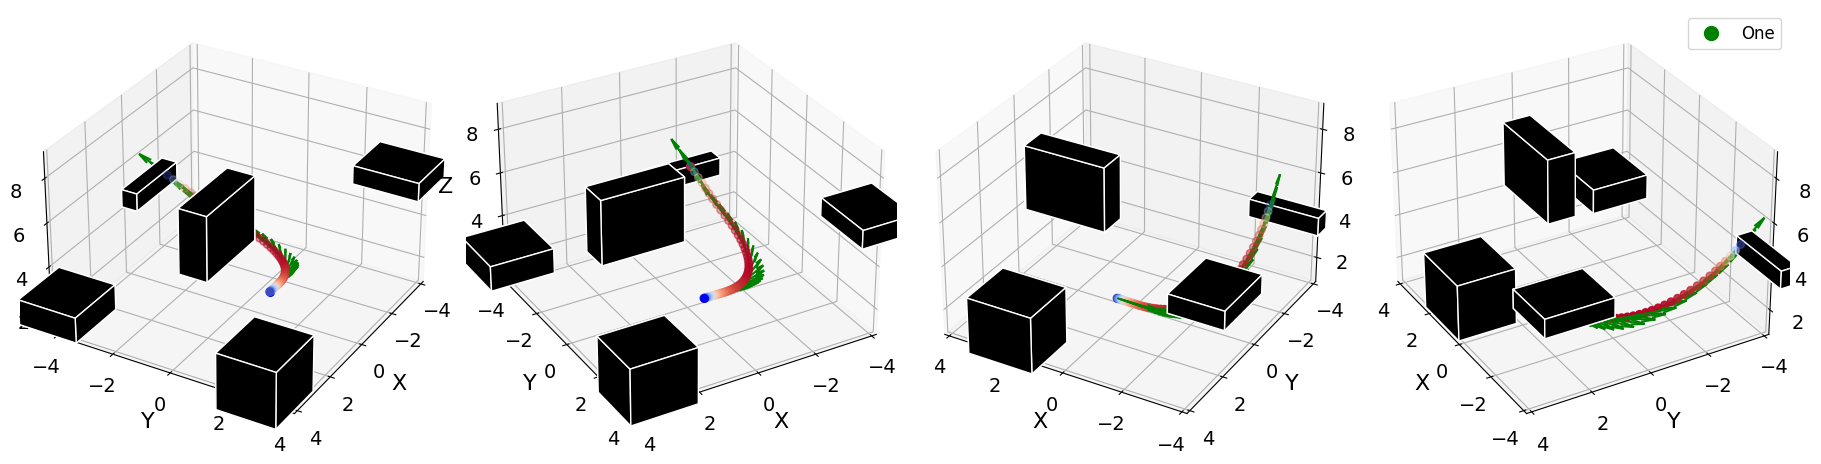

In [ ]:
#Filtered trajectory
initial_state = np.array([0, 1, 2, 0, 0, np.pi, 1])
T = 2.3
dt = 0.05
instanceNCBF = F16_Controller(initial_state, dt, filter = F16_DeepReach, alpha = .05)
trajectoryDeepReach = instanceNCBF.calculate_trajectory(T)

instanceNCBF.plot_trajectories([trajectoryDeepReach], ['One'], [ 'green'])

In [ ]:
#Save trajectory
# Save the trajectory using dill
with open('trajectory_DeepReach', 'wb') as file:
    dill.dump(trajectoryDeepReach, file)